In [63]:
import math
import numpy as np
import scipy
#import scipy.io
#import scipy.signal
import os
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import h5py
import torch
import torch.nn as nn
from tqdm import tqdm as tqdm
from torch.utils.tensorboard import SummaryWriter
import librosa
import librosa.display

In [2]:
folderpath = 'D:/PatientData/Procenko/records_03112021'
filenames = ['Patient001_test0042021.03.11_19.12.59.hdf5',
             'Patient001_test0052021.03.11_19.26.24.hdf5',
             'Patient001_test0062021.03.11_19.42.41.hdf5',
             'Patient001_test0072021.03.11_20.40.02.hdf5',
             'Patient001_test0082021.03.11_20.55.25.hdf5',
             'Patient001_test0092021.03.11_21.10.53.hdf5']
filepaths = [folderpath + '/' + filename for filename in filenames]

In [3]:
def prepare_data_ecog(filepath):
    FREQUENCY = 19200
    DOWNSAMPLING_COEF = 10
    FREQUENCY_DOWNSAMPLE = FREQUENCY // DOWNSAMPLING_COEF
    HIGH_PASS_FREQUENCY = 20
    NOTCH_FREQUENCY = (50, 100, 150)
    
    with h5py.File(filepath,'r+') as input_file:
        ecog = np.array(input_file['RawData']['Samples'][:, :30], dtype='double')

    # downsample
    ecog = scipy.signal.decimate(ecog, DOWNSAMPLING_COEF, axis=0)
    
    # remove eyes artifacts (hpf 20)
    bgamma, agamma = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (FREQUENCY_DOWNSAMPLE / 2), btype='high')
    ecog = scipy.signal.filtfilt(bgamma, agamma, ecog, axis=0)
    
    # notch for (50, 100, 150) Hz
    for w0 in NOTCH_FREQUENCY:
        norch_b, norch_a = scipy.signal.iirnotch(w0, Q=10, fs=FREQUENCY_DOWNSAMPLE)
        ecog = scipy.signal.filtfilt(norch_b, norch_a, ecog, axis=0)
        
    return ecog

In [158]:
FREQUENCY = 19200
scaler = sklearn.preprocessing.StandardScaler()

def prepare_data_sound(filepath, scaler):
    FREQUENCY = 19200
    HIGH_PASS_FREQUENCY = 200
    
    with h5py.File(filepath,'r+') as input_file:
        sound = np.array(input_file['RawData']['Samples'][:, 31], dtype='double')
        
    # remove ecog influence
    bhp, ahp = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (FREQUENCY / 2), btype='high')
    sound = scipy.signal.filtfilt(bhp, ahp, sound)
    
    scaler.partial_fit(sound.reshape(-1, 1))
    
    return sound, scaler

sound, scaler = prepare_data_sound(filepaths[0], scaler)
sound = scaler.transform(sound.reshape(-1, 1)).squeeze()

In [159]:
sound.shape

(12007936,)

In [160]:
# work with 10s chunk of sound
sound_chunk = sound[FREQUENCY*60:FREQUENCY*65]

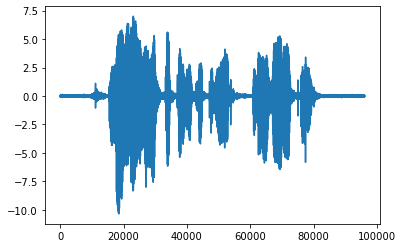

In [161]:
plt.plot(sound_chunk)

In [162]:
def extract_mfccs(sound, sr, i_mel, lngt):
    S = librosa.feature.melspectrogram(y=sound, sr=sr, n_mels=16,
                                    fmax=4000,hop_length=256)
    mfccs = librosa.feature.mfcc(S = librosa.power_to_db(S),n_mfcc = 16);
    the_mfcc = scipy.signal.resample(x = mfccs[:,:].T, num = lngt, axis=0).T
    return the_mfcc

In [149]:
window_size = 512
frame_size = window_size
hop_size = window_size // 4
overlap_size = window_size - hop_size
librosa_stft = librosa.stft(sound_chunk, n_fft=frame_size, hop_length=hop_size, 
                            win_length=window_size, window='hann', 
                            center=False, dtype=None, pad_mode='reflect')
# ['even', 'odd', 'constant', 'zeros', None]
f, t, scipy_stft = scipy.signal.stft(sound_chunk, nfft=frame_size, noverlap=overlap_size, 
                                     nperseg=frame_size, window='hann', detrend=False, 
                                     return_onesided=True, boundary='zeros', padded=True, fs=FREQUENCY)

In [150]:
print(librosa_stft.shape, scipy_stft.shape)

(257, 747) (257, 751)


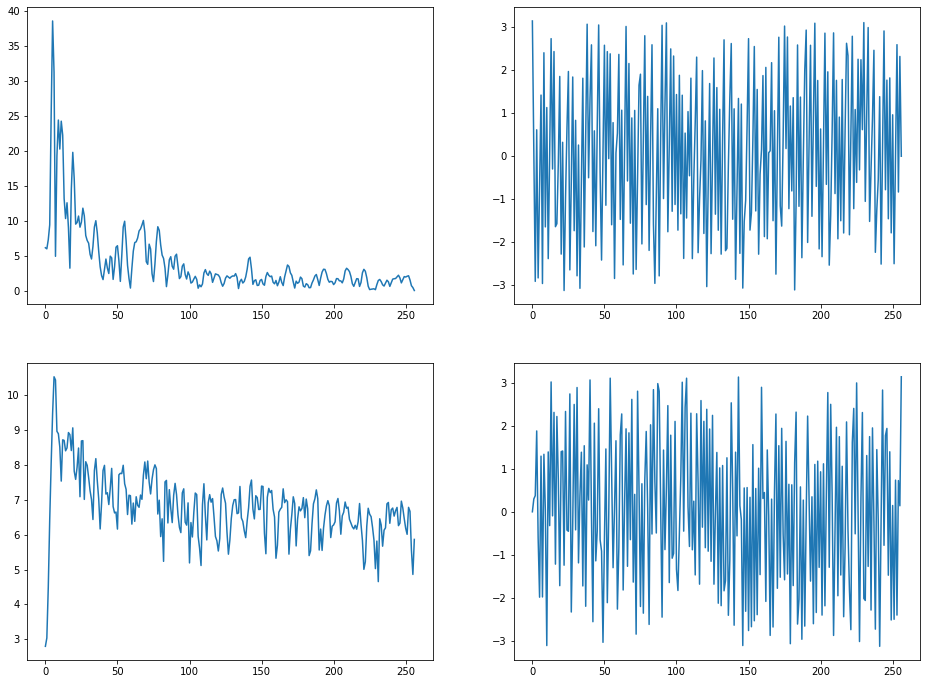

In [168]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
#snorm1 = np.real(librosa_stft[:, 0])
#snorm2 = np.abs(Zxx[:, 0])
ax[0, 0].plot(np.abs(scipy_stft[:, 0]))
ax[0, 1].plot(np.angle(scipy_stft[:, 0]))
ax[1, 0].plot(np.log(np.abs(librosa_stft[:, 0])))
ax[1, 1].plot(np.angle(librosa_stft[:, 0]))

In [173]:
np.amax(np.abs(scipy_stft))

9758.920329347815

<function matplotlib.pyplot.show(close=None, block=None)>

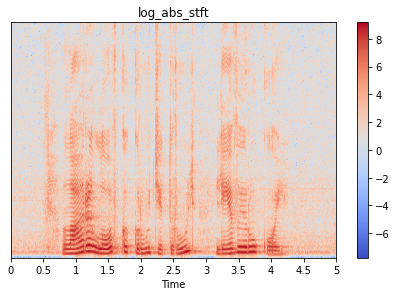

In [183]:
librosa.display.specshow(np.log(np.abs(scipy_stft)), x_axis='time', x_coords=t, y_coords=f, shading='auto')
plt.colorbar()
plt.tight_layout()
plt.title('log_abs_stft')
plt.show

In [180]:
scipy_stft.shape

(257, 751)

<function matplotlib.pyplot.show(close=None, block=None)>

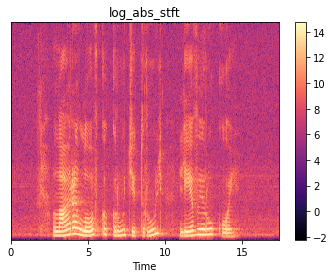

In [174]:
librosa.display.specshow(np.log(np.abs(librosa_stft)), x_axis='time')
plt.colorbar()
#plt.tight_layout()
plt.title('log_abs_stft')
plt.show